## 1) Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load dataset
df = pd.read_csv('Almond.csv')

numeric_features = ['Length (major axis)',      #Length of the almond in the image (based on number of pixels)
                    'Width (minor axis)',       #Width of the almond in the image (based on number of pixels)
                    'Thickness (depth)',        #Thickness of the almond in the image (based on number of pixels)  
                    'Area',                     #The area of the Almond region detected in the image
                    'Perimeter',                #Total length of the almond boundary
                    'Roundness',                #Roundness of the almond: 4 * area / ( pi * length ** 2)
                    'Solidity',                 #Area / area_hull
                    'Compactness',              #perimeter**2 / (4 * pi * area)
                    'Aspect Ratio',             #Length / Width
                    'Eccentricity',             #sqrt(1 - ( Width / Length ) **2 )
                    'Extent',                   #Area / area_bbox(bounding box)
                    'Convex hull(convex area)'] #smallest convex set that contains bounding points
main_features = ['Length (major axis)', 
                 'Width (minor axis)', 
                 'Thickness (depth)']

imputer = KNNImputer(n_neighbors=20) #Initialize the KNN imputer
df[main_features] = imputer.fit_transform(df[main_features]) #Impute the missing values
df['Roundness'] = 4 * (df['Area'] / (np.pi * df['Length (major axis)'] ** 2))
df['Aspect Ratio'] = df['Length (major axis)'] / df['Width (minor axis)']
df['Eccentricity'] = np.sqrt(1 - ( df['Width (minor axis)'] / df['Length (major axis)'] ) **2 )
print(df.head(10))
df = df.dropna()

# Initialize the Scalar
scaler = StandardScaler()
X = scaler.fit_transform(df[numeric_features])

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # sparse=False returns a dense array
y = encoder.fit_transform(df[['Type']])# Fit and transform the almond type column

#split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

   Unnamed: 0  Length (major axis)  Width (minor axis)  Thickness (depth)  \
0           0           324.399973          227.940628         127.759132   
1           1           326.243797          234.188126         128.199509   
2           2           346.203348          229.418610         125.796547   
3           3           338.549417          232.763153         125.918808   
4           4           323.601568          230.150742         107.253448   
5           5           298.477300          231.914429         107.759789   
6           6           297.917816          226.371048         106.479408   
7           7           301.994913          226.186142         102.623077   
8           8           413.477173          197.486449         138.190536   
9           9           418.210327          197.702801         129.659897   

      Area    Perimeter  Roundness  Solidity  Compactness  Aspect Ratio  \
0  22619.0   643.813269   0.273667  0.973384     1.458265      1.423177   
1 

c:\Users\christiaanm\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2) Hyperparameter Optimisation

### 2.1) Neural Architecture Search (NAS)

In [2]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

#==============================================================================================================

# Function to create a neural network model with variable layers, neurons, regularization & dropout
def create_model(num_layers = 3, neurons_per_layer = 128, learningrate=0.01, l2_value=0, dropout_rate=0.01):
    model = Sequential()
    
    #first hidden layer (with L2 regularization on both weights and biases)
    model.add(Dense(neurons_per_layer, input_dim=X.shape[1], activation='relu', 
                    kernel_regularizer=l2(l2_value), bias_regularizer=l2(l2_value)))  
    
    # Add hidden layers dynamically (L2 regularization and dropout included)
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu', 
                        kernel_regularizer=l2(l2_value), bias_regularizer=l2(l2_value)))
        model.add(Dropout(dropout_rate)) 
    
    # Output layer (no regularization on output layer)
    model.add(Dense(3, activation='softmax'))

    # compile the model
    optimizer = Adam(learning_rate=learningrate)  # Fixed learning rate
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

#==============================================================================================================

In [3]:
import random
from copy import deepcopy

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

################################################################################################################
# Function to perform cross-validation for a given set of hyperparameters
def evaluate_model_NAS(X_data, y_data, hp1, hp2, hp3, hp4):

    num_layers = hp1
    neurons_per_layer = hp2
    learningrate = 0.01 
    batchsize = 32
    dropout_rate = hp3
    l2_value = hp4

    loss_list = []
    accuracy_list = []

    for train_idx, test_idx in kf.split(X_data):
        model = create_model(num_layers, neurons_per_layer, learningrate, l2_value, dropout_rate)
        model.fit(X_data[train_idx], y_data[train_idx], epochs=50, batch_size=batchsize, verbose=0)
        loss, accuracy = model.evaluate(X_data[test_idx], y_data[test_idx], verbose=0)
        loss_list.append(loss)
        accuracy_list.append(accuracy)
    
    return np.mean(loss_list), np.std(loss_list), np.mean(accuracy_list), np.std(accuracy_list)

################################################################################################################
# we define the hyperparmeter ranges
hyperparameter_space = {
    'num_layers': [1, 2, 3, 4, 5, 6],
    'neurons_per_layer': [8, 16, 32, 64, 128, 256],
    # 'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    # 'batch_size': [8, 16, 32, 64, 128, 256],
    'dropout_rate': [0, 0.01, 0.1, 0.25, 0.5],
    'l2_value': [0, 0.01, 0.05, 0.1, 0.5]
}

################################################################################################################
# create a function to randomly pick from the hyperparameters ranges - used to generate a random model
def generate_random_model():
    return {
        'num_layers': random.choice(hyperparameter_space['num_layers']),
        'neurons_per_layer': random.choice(hyperparameter_space['neurons_per_layer']),
        # 'learning_rate': random.choice(hyperparameter_space['learning_rate']),
        # 'batch_size': random.choice(hyperparameter_space['batch_size']),
        'dropout_rate': random.choice(hyperparameter_space['dropout_rate']),
        'l2_value': random.choice(hyperparameter_space['l2_value'])
    }

################################################################################################################
# define CROSSOVER function: combine hyperparameters from two models
def crossover(parent1, parent2):
    child = {}
    for key in parent1:
        child[key] = random.choice([parent1[key], parent2[key]])  #choose value from one of the parents
    return child

################################################################################################################
# define MUTATION function: apply random changes to hyperparameters
def mutate(model):
    mutated_model = deepcopy(model) # changes made to the copy are completely independent of the original object
    if random.random() < 0.5:  # 50% chance to mutate each hyperparameter
        mutated_model['num_layers'] = random.choice(hyperparameter_space['num_layers'])
    if random.random() < 0.5:
        mutated_model['neurons_per_layer'] = random.choice(hyperparameter_space['neurons_per_layer'])
    # if random.random() < 0.5:
    #     mutated_model['learning_rate'] = random.choice(hyperparameter_space['learning_rate'])
    # if random.random() < 0.5:
    #     mutated_model['batch_size'] = random.choice(hyperparameter_space['batch_size'])
    if random.random() < 0.5:
        mutated_model['dropout_rate'] = random.choice(hyperparameter_space['dropout_rate'])
    if random.random() < 0.5:
        mutated_model['l2_value'] = random.choice(hyperparameter_space['l2_value'])
    return mutated_model

################################################################################################################
#efine the Evolutionary NAS Algorithm
def evolutionary_search(X_train, y_train, population_size=10, generations=5, mutation_rate=0.1, top_k=3):
    
    #=========================================================================================================
    #STEP 1: Initialize & Evaluate the population (set of randomly selected hyperparams)
    population = [generate_random_model() for _ in range(population_size)]
    # print(population)

    for gen in range(generations):
        print(f"\n=== Generation {gen + 1} ===" )

    #=========================================================================================================
        # STEP 2: evaluate the population
        performance = []
        for model_params in population:
            print(f"Evaluating: {model_params}")
            mean_loss, std_loss, mean_acc, std_acc = evaluate_model_NAS(X_train, y_train, 
                                                                    model_params['num_layers'], 
                                                                    model_params['neurons_per_layer'], 
                                                                    model_params['dropout_rate'], 
                                                                    model_params['l2_value'])
            performance.append((model_params, mean_acc))
        # print('performance array:', performance)

        # Sort by accuracy and select the top K models
        ranked_pop = sorted(performance, key=lambda x: x[1], reverse=True) #x[1] = model accuracy, defined with key to also sort both params & accuracy according to ONLY accuracy
        # print('ranked array:', ranked_pop)
        
        best_models = []
        best_acc = []
        for i in range(top_k):
            best_models.append(ranked_pop[i][0])
            best_acc.append(ranked_pop[i][1])
            print( f"Rank {i+1} model: {best_models[i]} | accuracy: {best_acc[i]}" )

        if gen != generations:

        #=========================================================================================================
            #STEP 3: mutate the top_k models
            new_population = deepcopy(best_models)
            for model in new_population:
                if random.random() < mutation_rate:
                    mutated_model = mutate(model)
                    new_population.append(mutated_model) #add mutated models to best models

        #=========================================================================================================
            # STEP 4: crossover (create children by combining top models)
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(best_models, 2)
                child = crossover(parent1, parent2)
                new_population.append(child) #add children from best models to model list

            population = new_population

    # OUTPUT: best model from the final population:
    return best_models[0], best_acc[0]

In [4]:
# RUN Evolutionary NAS algorithm
# best_params = evolutionary_search(X_train, y_train, population_size=10, generations=5, mutation_rate=0.1, top_k=3)

In [5]:
# Since this document had to be run mulitple times, it doesn't make sense to also run the NAS algorithm every time. So the results from a previous NAS run has been hardcoded here.
best_params = ({
    'num_layers': 3,
    'neurons_per_layer': 128,
    'dropout_rate': 0.01,
    'l2_value': 0}, 0.7552305579185485)
print(f'best_params: {best_params[0]} | accuracy: {best_params[1]}')

best_params: {'num_layers': 3, 'neurons_per_layer': 128, 'dropout_rate': 0.01, 'l2_value': 0} | accuracy: 0.7552305579185485


### 2.2) Grid Search - Learning Rate vs Batchsize

In [6]:
from scipy import stats

# Hyperparameters for grid search
# num_layers_options = [1, 2, 3, 4, 5, 6]  # Number of layers
# neurons_per_layer_options = [8, 16, 32, 64, 128, 256]  # Neurons per layer
learning_rate_options = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5] # Learning Rates
batch_size_options = [8, 16, 32, 64, 128, 256] # Batch Sizes
# learning_rate_options = [0.01, 0.05, 0.1] # Learning Rates
# batch_size_options = [32, 64, 128] # Batch Sizes
# dropout_rate_options = [0, 0.01, 0.1, 0.25, 0.5, 0.75] # Dropout Rates
# l2_value_options = [0, 0.01, 0.05, 0.1, 0.5] # l2_Value Options

################################################################################################################
# Function to perform cross-validation for a given set of hyperparameters
def evaluate_model(X_data, y_data, hp1, hp2, NAS_params, case):

    if case == 1:
        num_layers = hp1
        neurons_per_layer = hp2
        learningrate = 0.01 
        batchsize = 256
        dropout_rate = 0.01
        l2_value = 0
        
    elif case == 2:
        # num_layers = 5
        # neurons_per_layer = 128
        # learningrate = hp1
        # batchsize = hp2
        # dropout_rate = 0.01
        # l2_value = 0   

        num_layers = NAS_params['num_layers']
        neurons_per_layer = NAS_params['neurons_per_layer']
        learningrate = hp1
        batchsize = hp2
        dropout_rate = NAS_params['dropout_rate']
        l2_value = NAS_params['l2_value']

    elif case == 3:
        num_layers = 5
        neurons_per_layer = 128
        learningrate = 0.01 
        batchsize = 256
        dropout_rate = hp1
        l2_value = hp2 

    loss_list = []
    accuracy_list = []

    for train_idx, test_idx in kf.split(X_data):
        model = create_model(num_layers, neurons_per_layer, learningrate, l2_value, dropout_rate)
        model.fit(X_data[train_idx], y_data[train_idx], epochs=50, batch_size=batchsize, verbose=0)
        loss, accuracy = model.evaluate(X_data[test_idx], y_data[test_idx], verbose=0)
        loss_list.append(loss)
        accuracy_list.append(accuracy)
    
    return np.mean(loss_list), np.std(loss_list), np.mean(accuracy_list), np.std(accuracy_list)

################################################################################################################
accuracy_results_hp1 = {}
accuracy_results_hp2 = {}
stddev_results_hp1 = {}
stddev_results_hp2 = {}
def Heatmap_Gridsearch(case, HP_1, HP_2, NAS_params, plot_title = 'Mean Accuracy Heatmap for Number of Layers vs Neurons Per Layer', x_label = 'Neurons Per Layer', y_label = 'Number of Layers'):
    # Store results
    results = {}
    for hp1 in HP_1:
        for hp2 in HP_2:
            mean_loss, std_loss, mean_acc, std_acc = evaluate_model(X_train, y_train, hp1, hp2, NAS_params, case)
            results[(hp1, hp2)] = (mean_acc, std_acc)

    # store the accuracies in separate lists for each hyperparameter
            if hp1 not in accuracy_results_hp1:
                accuracy_results_hp1[hp1] = []
                stddev_results_hp1[hp1] = []
            if hp2 not in accuracy_results_hp2:
                accuracy_results_hp2[hp2] = []
                stddev_results_hp2[hp2] = []
                
            accuracy_results_hp1[hp1].append(mean_acc)
            accuracy_results_hp2[hp2].append(mean_acc)
            stddev_results_hp1[hp1].append(std_acc)
            stddev_results_hp2[hp2].append(std_acc)

            print(f"{y_label}: {hp1}, {x_label}: {hp2}, Mean Loss: {mean_loss}, Loss Std Dev: {std_loss}, Mean Accuracy: {mean_acc}, Acc Std Dev: {std_acc}")

    # create heatmap data
    heatmap_data = np.zeros((len(HP_1), len(HP_2)))
    for i, hp1 in enumerate(HP_1):
        for j, hp2 in enumerate(HP_2):
            heatmap_data[i, j] = results[(hp1, hp2)][0]

    #plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", xticklabels=HP_2, yticklabels=HP_1, cmap='magma')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.show()

    return accuracy_results_hp1, accuracy_results_hp2, stddev_results_hp1, stddev_results_hp2

c:\Users\christiaanm\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Learning Rates: 0.001, Batch Sizes: 8, Mean Loss: 0.8039608597755432, Loss Std Dev: 0.03200667681624261, Mean Accuracy: 0.7669457793235779, Acc Std Dev: 0.011431296039326867
Learning Rates: 0.001, Batch Sizes: 16, Mean Loss: 0.6777285814285279, Loss Std Dev: 0.04275709027542352, Mean Accuracy: 0.773074722290039, Acc Std Dev: 0.01888584939680855
Learning Rates: 0.001, Batch Sizes: 32, Mean Loss: 0.6348237752914428, Loss Std Dev: 0.04188034201289563, Mean Accuracy: 0.7695071816444397, Acc Std Dev: 0.014180304949061312
Learning Rates: 0.001, Batch Sizes: 64, Mean Loss: 0.6142867088317872, Loss Std Dev: 0.05735135868054825, Mean Accuracy: 0.7659513354301453, Acc Std Dev: 0.026125201513879596
Learning Rates: 0.001, Batch Sizes: 128, Mean Loss: 0.6018878698349, Loss Std Dev: 0.04206358047900468, Mean Accuracy: 0.7521771311759948, Acc Std Dev: 0.019650768027665064
Learning Rates: 0.001, Batch Sizes: 256, Mean Loss: 0.5833479046821595, Loss Std Dev: 0.020086869940407318, Mean Accuracy: 0.75165

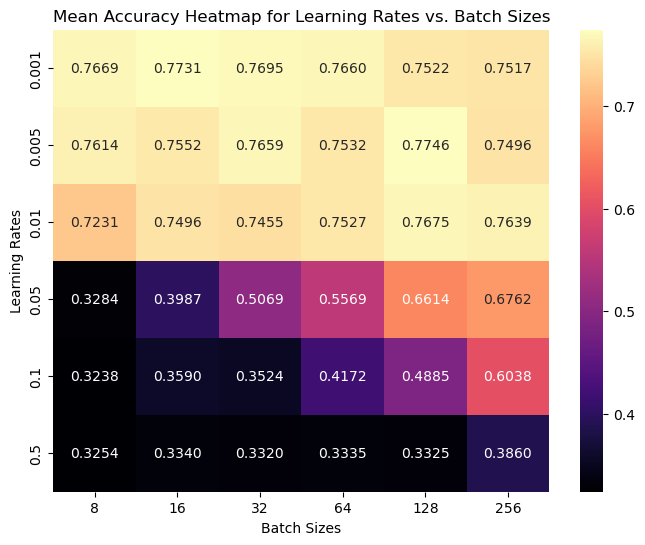

In [7]:
accuracy_hp1, accuracy_hp2, stddev_hp1, stddev_hp2 = Heatmap_Gridsearch(2,
                                                learning_rate_options,
                                                batch_size_options,
                                                best_params[0], 
                                                plot_title = 'Mean Accuracy Heatmap for Learning Rates vs. Batch Sizes', 
                                                x_label = 'Batch Sizes', 
                                                y_label = 'Learning Rates')

c:\Users\christiaanm\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Loss: 0.13626201450824738
Train Accuracy: 0.9495155811309814
Test Loss: 0.7630377411842346
Test Accuracy: 0.7954815626144409


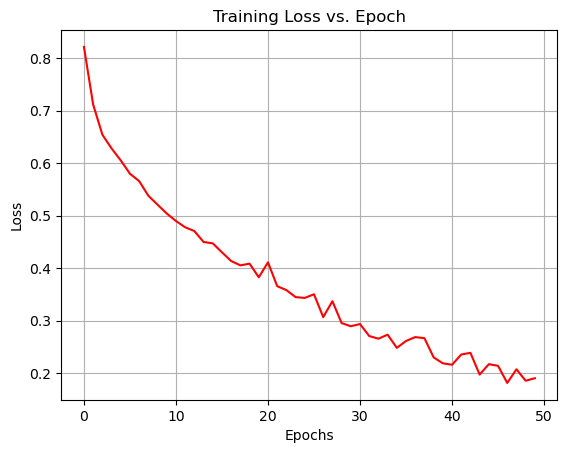

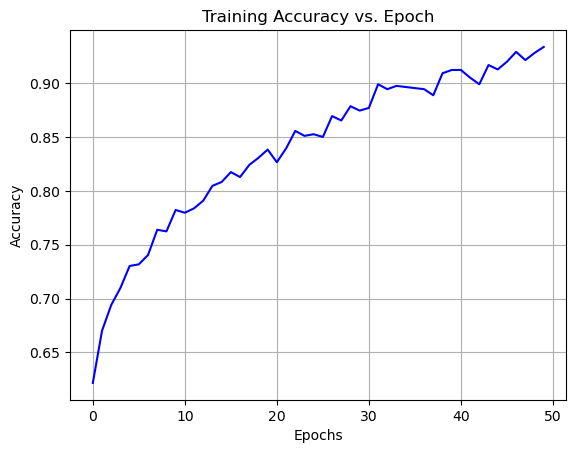

In [8]:
# Evaluate optimized model performance on training and testing data
model = create_model(num_layers = 3, neurons_per_layer = 128, learningrate=0.001, l2_value=0, dropout_rate=0.01)
HISTORY = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Train Loss:',train_loss)
print('Train Accuracy:',train_accuracy)
print('Test Loss:',test_loss)
print('Test Accuracy:',test_accuracy)

plt.figure()
plt.plot(HISTORY.history['loss'], color='red', linestyle='-')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(HISTORY.history['accuracy'], color='blue', linestyle='-')
plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 2.3) Statistical Investigation

In [9]:
print(accuracy_hp1)
print(accuracy_hp2)
print(stddev_hp1)
print(stddev_hp2)

{0.001: [0.7669457793235779, 0.773074722290039, 0.7695071816444397, 0.7659513354301453, 0.7521771311759948, 0.7516552448272705], 0.005: [0.7613556027412415, 0.7552292704582214, 0.7659331679344177, 0.7532001256942749, 0.7746170163154602, 0.7496131300926209], 0.01: [0.7230955123901367, 0.7496377944946289, 0.7455353975296021, 0.7526938199996949, 0.7674715638160705, 0.763901436328888], 0.05: [0.3284182369709015, 0.39874071478843687, 0.5068728208541871, 0.55685595870018, 0.6613672971725464, 0.6761813759803772], 0.1: [0.32382639646530154, 0.35900970101356505, 0.35236796736717224, 0.41716389656066893, 0.4884976983070374, 0.603766143321991], 0.5: [0.3253570139408112, 0.33403047919273376, 0.3319896638393402, 0.3335202753543854, 0.3324700057506561, 0.38602715730667114]}
{8: [0.7669457793235779, 0.7613556027412415, 0.7230955123901367, 0.3284182369709015, 0.32382639646530154, 0.3253570139408112], 16: [0.773074722290039, 0.7552292704582214, 0.7496377944946289, 0.39874071478843687, 0.359009701013565

In [10]:
#Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(accuracy_hp1[0.001], accuracy_hp1[0.1])
# t_stat, p_value = stats.ttest_ind(accuracy_hp2[8], accuracy_hp2[128])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check if p-value is less than a significance level (0.05)
if p_value < 0.05:
    print("There is statistical evidence that the performance differs between the two hyperparameters.")
else:
    print("There is no statistical evidence that the performance differs between the two hyperparameters.")

T-statistic: 7.826214227165891
P-value: 1.4265178693357764e-05
There is statistical evidence that the performance differs between the two hyperparameters.


In [11]:
# Heatmap_Gridsearch(1,
#                    num_layers_options,
#                    neurons_per_layer_options, 
#                    plot_title = 'Mean Accuracy Heatmap for Number of Layers vs. Neurons Per Layer', 
#                    x_label = 'Neurons Per Layer', 
#                    y_label = 'Number of Layers')

# Heatmap_Gridsearch(2,
#                    learning_rate_options,
#                    batch_size_options, 
#                    plot_title = 'Mean Accuracy Heatmap for Learning Rates vs. Batch Sizes', 
#                    x_label = 'Batch Sizes', 
#                    y_label = 'Learning Rates')

# Heatmap_Gridsearch(3,
#                    dropout_rate_options,
#                    l2_value_options, 
#                    plot_title = 'Mean Accuracy Heatmap for Dropout Rates vs. L2 Regularizer Lamda Values', 
#                    x_label = 'L2 Regularizer Lamda Values', 
#                    y_label = 'Dropout Rates')

## 3) Hybrid Learning

### 3.1) Training Algorithm Optimisation

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create NN according to pytorch methods
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_layers=3, neurons_per_layer=128):
        super(SimpleNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(neurons_per_layer, 3))  # 3 output classes
        layers.append(nn.Softmax(dim=1))  # Softmax for multi-class classification as stated in doxument
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to train the model and store training and validation accuracy
def train_pytorch(model, optimizer, loss_fn, X_train, y_train, X_val, y_val, epochs=50):
    history = {'tr_accuracy': [], 'val_accuracy': [], 'tr_loss': [], 'val_loss': []}  # Add 'loss' to history
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        

        history['tr_loss'].append(loss.item()) 


        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(y_train, 1)
        train_accuracy = (predicted == labels).float().mean().item()
        history['tr_accuracy'].append(train_accuracy)


        model.eval()  #   evaluation mode
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            history['val_loss'].append(val_loss)
            _, val_predicted = torch.max(val_outputs, 1)
            _, val_labels = torch.max(y_val, 1)
            val_accuracy = (val_predicted == val_labels).float().mean().item()
            history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch [{epoch + 1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')
    return history

#==================================================================================================================================================

def train_pytorch_hybrid2(model, optimizer1, optimizer2, loss_fn, X_train, y_train, X_val, y_val, epochs=50):
    history = {'tr_accuracy': [], 'val_accuracy': [], 'tr_loss': [], 'val_loss': []} 

    for epoch in range(epochs):
        model.train()

        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        # BACKWARD pass to compute gradients
        loss.backward()

        # optimizer1.step()

        with torch.no_grad():
            # Save original parameter values before updates
            original_params = [p.clone() for p in model.parameters()]

            #step with optimizer1
            optimizer1.step()  # This will modify the model's weights

            #Calculate updates for optimizer1
            param1_updates = [(p.data - original_params[i]) for i, p in enumerate(model.parameters())]

            # restore original parameter values for the next optimizer
            for i, p in enumerate(model.parameters()):
                p.data = original_params[i]

            optimizer2.step() 
            param2_updates = [(p.data - original_params[i]) for i, p in enumerate(model.parameters())]
            for i, p in enumerate(model.parameters()):
                p.data = original_params[i]

            # average of the updates
            for i, p in enumerate(model.parameters()):
                avg_update = (0.5*param1_updates[i] + 0.5*param2_updates[i])
                p.data = original_params[i] + avg_update

  
        history['tr_loss'].append(loss.item())


        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(y_train, 1)
        train_accuracy = (predicted == labels).float().mean().item()
        history['tr_accuracy'].append(train_accuracy)

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            history['val_loss'].append(val_loss)
            _, val_predicted = torch.max(val_outputs, 1)
            _, val_labels = torch.max(y_val, 1)
            val_accuracy = (val_predicted == val_labels).float().mean().item()
            history['val_accuracy'].append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    return history

In [13]:
RUNS = 5
adam_A = 0
adam_VA = 0
adam_L = 0
adam_VL = 0
rprop_A = 0
rprop_VA = 0
rprop_L = 0
rprop_VL = 0
hybrid_A = 0
hybrid_VA = 0
hybrid_L = 0
hybrid_VL = 0

for i in range(RUNS):
    # #Keras: Adam optimizer
    # model_adam = create_model()
    # model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # history_adam = model_adam.fit(X_train, y_train, epochs=50, batch_size=len(X_train), validation_data=(X_val, y_val))
    
#==================================================================================================================================================
    #Since Rprop optimiser doesn't work on mini-batches for training, we will use full-batch training for both optimisers.

    #PyTorch: Adam optimizer
    model = SimpleNN(input_size=X.shape[1])
    loss_fn = nn.CrossEntropyLoss()
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    history_adam = train_pytorch(model, optimizer_adam, loss_fn, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=50)

    # PyTorch: Rprop optimizer
    model = SimpleNN(input_size=X.shape[1])
    loss_fn = nn.CrossEntropyLoss()
    optimizer_rprop = optim.Rprop(model.parameters(), lr=0.001)
    history_rprop = train_pytorch(model, optimizer_rprop, loss_fn, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=50)

    # PyTorch: HYBRID
    model2 = SimpleNN(input_size=X.shape[1])
    loss_fn2 = nn.CrossEntropyLoss()
    optimizer_adam2 = optim.Adam(model2.parameters(), lr=0.001)
    optimizer_rprop2 = optim.Rprop(model2.parameters(), lr=0.001)
    history_hybrid = train_pytorch_hybrid2(model2, optimizer_rprop2, optimizer_adam2, loss_fn2, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=50)
    #==================================================================================================================================================

    adam_A = adam_A + np.array(history_adam['tr_accuracy'])
    adam_VA = adam_VA + np.array(history_adam['val_accuracy'])
    adam_L = adam_L + np.array(history_adam['tr_loss'])
    adam_VL = adam_VL + np.array(history_adam['val_loss'])
    rprop_A = rprop_A + np.array(history_rprop['tr_accuracy'])
    rprop_VA = rprop_VA + np.array(history_rprop['val_accuracy'])
    rprop_L = rprop_L + np.array(history_rprop['tr_loss'])
    rprop_VL = rprop_VL + np.array(history_rprop['val_loss'])
    hybrid_A = hybrid_A + np.array(history_hybrid['tr_accuracy'])
    hybrid_VA = hybrid_VA + np.array(history_hybrid['val_accuracy'])
    hybrid_L = hybrid_L + np.array(history_hybrid['tr_loss'])
    hybrid_VL = hybrid_VL + np.array(history_hybrid['val_loss'])

HISTORY_adam = {'accuracy': list(adam_A/RUNS), 'val_accuracy': list(adam_VA/RUNS), 'loss': list(adam_L/RUNS), 'val_loss': list(adam_VL/RUNS)}
HISTORY_rprop = {'accuracy': list(rprop_A/RUNS), 'val_accuracy': list(rprop_VA/RUNS), 'loss': list(rprop_L/RUNS), 'val_loss': list(rprop_VL/RUNS)}
HISTORY_hybrid = {'accuracy': list(hybrid_A/RUNS), 'val_accuracy': list(hybrid_VA/RUNS), 'loss': list(hybrid_L/RUNS), 'val_loss': list(hybrid_VL/RUNS)}

Epoch [1/50], Train Accuracy: 0.3279, Validation Accuracy: 0.3435, Train Loss: 1.0992, Validation Loss: 1.0933
Epoch [2/50], Train Accuracy: 0.3340, Validation Accuracy: 0.3690, Train Loss: 1.0942, Validation Loss: 1.0879
Epoch [3/50], Train Accuracy: 0.3559, Validation Accuracy: 0.4198, Train Loss: 1.0892, Validation Loss: 1.0825
Epoch [4/50], Train Accuracy: 0.4156, Validation Accuracy: 0.4555, Train Loss: 1.0842, Validation Loss: 1.0769
Epoch [5/50], Train Accuracy: 0.4488, Validation Accuracy: 0.4758, Train Loss: 1.0790, Validation Loss: 1.0706
Epoch [6/50], Train Accuracy: 0.4697, Validation Accuracy: 0.5013, Train Loss: 1.0733, Validation Loss: 1.0638
Epoch [7/50], Train Accuracy: 0.4814, Validation Accuracy: 0.5064, Train Loss: 1.0670, Validation Loss: 1.0563
Epoch [8/50], Train Accuracy: 0.4952, Validation Accuracy: 0.5115, Train Loss: 1.0601, Validation Loss: 1.0482
Epoch [9/50], Train Accuracy: 0.5115, Validation Accuracy: 0.5216, Train Loss: 1.0526, Validation Loss: 1.0398
E

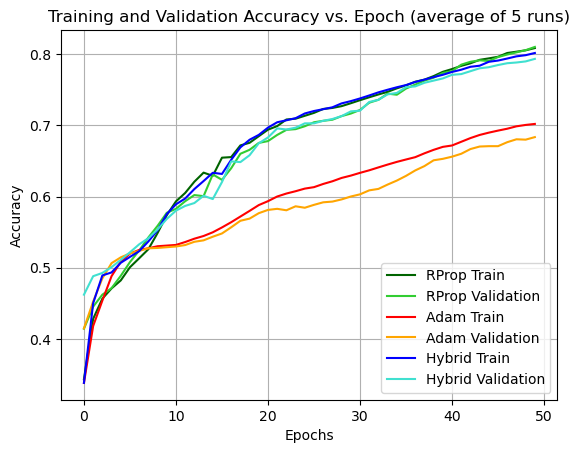

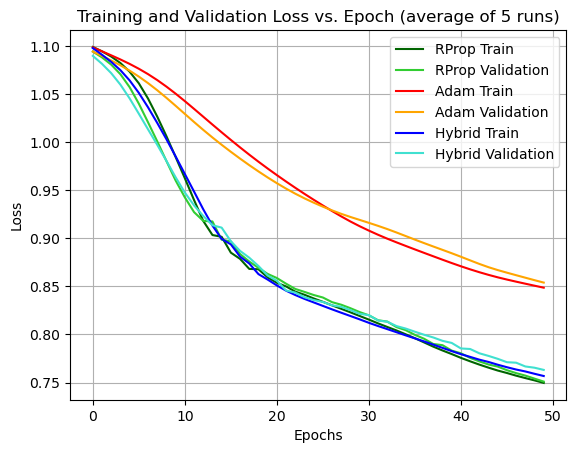

In [14]:
# Plot training vs validation accuracy for both
plt.figure()#figsize=(12, 5))

# plotting keras history
# plt.plot(history_adam.history['accuracy'], color='blue', linestyle='-', label='RMSProp Train')
# plt.plot(history_adam.history['val_accuracy'], color='turquoise', linestyle='-', label='RMSProp Validation')

plt.plot(HISTORY_rprop['accuracy'], color='darkgreen', linestyle='-', label='RProp Train')
plt.plot(HISTORY_rprop['val_accuracy'], color='limegreen', linestyle='-', label='RProp Validation')
plt.plot(HISTORY_adam['accuracy'], color='red', linestyle='-', label='Adam Train')
plt.plot(HISTORY_adam['val_accuracy'], color='orange', linestyle='-', label='Adam Validation')
plt.plot(HISTORY_hybrid['accuracy'], color='blue', linestyle='-', label='Hybrid Train')
plt.plot(HISTORY_hybrid['val_accuracy'], color='turquoise', linestyle='-', label='Hybrid Validation')

plt.legend()
plt.title('Training and Validation Accuracy vs. Epoch (average of 5 runs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


plt.figure()#figsize=(12, 5))
plt.plot(HISTORY_rprop['loss'], color='darkgreen', linestyle='-', label='RProp Train')
plt.plot(HISTORY_rprop['val_loss'], color='limegreen', linestyle='-', label='RProp Validation')
plt.plot(HISTORY_adam['loss'], color='red', linestyle='-', label='Adam Train')
plt.plot(HISTORY_adam['val_loss'], color='orange', linestyle='-', label='Adam Validation')
plt.plot(HISTORY_hybrid['loss'], color='blue', linestyle='-', label='Hybrid Train')
plt.plot(HISTORY_hybrid['val_loss'], color='turquoise', linestyle='-', label='Hybrid Validation')

plt.legend()
plt.title('Training and Validation Loss vs. Epoch (average of 5 runs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()